# Банки: сегментация пользователей по потреблению

Ссылка на презентацию: <https://drive.google.com/file/d/1EXfJjcNE6xsCbOdyKbXLYXvM64y_iov9/view?usp=sharing>

Ссылка на дашборд: https://public.tableau.com/app/profile/.20067662/viz/_16848773467100/sheet1

## Изучение общей информации о датасете

In [4]:
#импортируем библиотеки:
import os
import pandas as pd
import math
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from scipy import stats as st
from plotly import graph_objects as go
from statsmodels. stats.weightstats import ztest as ztest
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.float_format", "{:.2f}".format)

from datetime import datetime, timedelta

In [5]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
data_banks = pd.read_csv(path)
data_banks.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1


In [6]:
#переименуем  столбцы:
data_banks = data_banks.rename(columns = {'USERID': 'user_id', 'EST_SALARY': 'estimated_salary'})
data_banks

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.00,Рыбинск,М,27.00,1,78144.65,1,0,1,18943.64,0
9996,139170,894.00,Ярославль,М,46.00,0,NaN,1,1,0,196898.29,0
9997,115639,903.00,Ярославль,М,24.00,0,NaN,2,1,1,108905.09,0
9998,148700,777.00,Ярославль,Ж,68.00,3,865457.97,3,0,1,86874.90,0


In [7]:
data_banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  float64
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               9974 non-null   float64
 5   equity            10000 non-null  int64  
 6   balance           7705 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   last_activity     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Данные вполне корректны.

In [8]:
print(data_banks['balance'].isnull().sum())
print('В столбце balance {} % пропусков'. format(data_banks['balance'].isnull().sum()/len(data_banks)*100))

2295
В столбце balance 22.95 % пропусков


In [9]:
print(data_banks['age'].isnull().sum())
print('В столбце age {} % пропусков'. format(data_banks['age'].isnull().sum()/len(data_banks)*100))

26
В столбце age 0.26 % пропусков


Судя по всему, можно удалить строки с пропусками по возрасту, их слишком мало, однако почти 23% пропусков в балансе вызывают дополнительные вопросы и их стоит проверить отдельно.

In [10]:
data_banks.dropna(subset = ['age'], inplace=True)

In [11]:
#методом describe проанализируем пропуски:
display (data_banks[data_banks['balance'].isna()].describe())

,user_id,score,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
count,2279.00,2279.00,2279.00,2279.00,0.00,2279.00,2279.00,2279.00,2279.00,2279.00
mean,171904.89,865.36,42.09,0.05,NaN,1.16,0.82,0.55,226345.42,0.01
std,33303.22,89.55,11.94,0.23,NaN,0.40,0.39,0.50,199825.59,0.08
min,114182.00,642.00,18.00,0.00,NaN,0.00,0.00,0.00,20274.03,0.00
25%,142992.50,871.00,33.00,0.00,NaN,1.00,1.00,0.00,120217.39,0.00
50%,172304.00,903.00,40.00,0.00,NaN,1.00,1.00,1.00,174347.87,0.00
75%,201257.00,922.00,49.00,0.00,NaN,1.00,1.00,1.00,240372.78,0.00
max,229145.00,990.00,86.00,3.00,NaN,3.00,1.00,1.00,1333687.36,1.00


In [12]:
#и сравним с результатом для всего датасета:
data_banks.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
count,9974.00,9974.00,9974.00,9974.00,7695.00,9974.00,9974.00,9974.00,9974.00,9974.00
mean,171755.22,848.68,42.73,2.63,827245.59,1.87,0.68,0.52,147786.81,0.18
std,33695.53,65.40,12.18,1.98,1980327.41,0.79,0.47,0.50,139285.51,0.39
min,94561.00,642.00,18.00,0.00,0.00,0.00,0.00,0.00,2546.30,0.00
25%,142760.00,802.00,33.00,0.00,295698.71,1.00,0.00,0.00,75251.66,0.00
50%,172643.00,853.00,40.00,3.00,524295.33,2.00,1.00,1.00,119626.79,0.00
75%,201163.75,900.00,51.00,4.00,980051.21,2.00,1.00,1.00,174499.81,0.00
max,229145.00,1000.00,86.00,9.00,119113552.01,5.00,1.00,1.00,1395064.45,1.00


Судя по всему, у тех клиентов, у которых пропуски в балансе, в среднем повыше зарплата,меньшее количество используемых продуктов и намного меньше капиталов собсвенности. Тк это довольное большое количество пользователей, удалять данные считаю нецелесообразным, предположу, что относятся к типу MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от переменных, которых нет в данных, объяснить взаимосвязи с данными не получается, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.

Также обращает на себя внимание факт, что минимальное количество используемых продуктов равно 0, однако на мой взгляд, у клиента банка должен быть хоть 1 продукт. А также минимальная зарплата, равная 2,5 тыс. рублям. Явно ниже МРОТ. Изучим эти моменты.

In [13]:
data_banks[data_banks['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
8957,147837,962.00,Рыбинск,Ж,79.00,3,NaN,0,0,0,25063.96,1


Всего 1 человек, можно его удалить.

In [14]:
data_banks = data_banks[data_banks['products']!=0]

Тк основная часть наших датасетов приходилась примерно на 2019 г., возьмем МРОТ на этот же период, на 1 января 2019 г. он составлял 11280 руюлей, округлим до 12 тыс. рублей и посмотрим, как много пользователей с такой зарплатой.

In [15]:
data_banks[data_banks['estimated_salary']<12000]['user_id'].count()

32

Их всего 32, думаю, стоит тоже удалить.

In [16]:
data_banks = data_banks[data_banks['estimated_salary']>12000]

In [17]:
data_banks[data_banks['estimated_salary']>1000000]['user_id'].count()

59

У нас есть еще 59 человек с зарплатой выше 1 млн рублей, но их пока оставим, тк возможно это кто-то из топ-менеджеров и в случае чего, проще их как выброс, убрать позднее.

In [18]:
data_banks_dup = data_banks[data_banks.duplicated(subset=['user_id'])==True]
data_banks_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1583 to 9970
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           50 non-null     int64  
 1   score             50 non-null     float64
 2   city              50 non-null     object 
 3   gender            50 non-null     object 
 4   age               50 non-null     float64
 5   equity            50 non-null     int64  
 6   balance           31 non-null     float64
 7   products          50 non-null     int64  
 8   credit_card       50 non-null     int64  
 9   last_activity     50 non-null     int64  
 10  estimated_salary  50 non-null     float64
 11  churn             50 non-null     int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 5.1+ KB


Думаю, 50 дублей по ID можно также удалить, это менее 1 %.

In [19]:
data_banks = data_banks.drop_duplicates(subset='user_id')
data_banks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9891 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           9891 non-null   int64  
 1   score             9891 non-null   float64
 2   city              9891 non-null   object 
 3   gender            9891 non-null   object 
 4   age               9891 non-null   float64
 5   equity            9891 non-null   int64  
 6   balance           7632 non-null   float64
 7   products          9891 non-null   int64  
 8   credit_card       9891 non-null   int64  
 9   last_activity     9891 non-null   int64  
 10  estimated_salary  9891 non-null   float64
 11  churn             9891 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1004.6+ KB


In [20]:
#далее необходимо закодировать пол и города для корректной дальнейшей работы
#для начала надо создать копии столбцов city и gender:
data_banks['city_new']=data_banks['city']
data_banks['gender_new']=data_banks['gender']
data_banks.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn,city_new,gender_new
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1,Рыбинск,Ж
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0,Рыбинск,Ж
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0,Рыбинск,Ж
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1,Ярославль,Ж
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1,Ярославль,М


In [21]:
#затем закодируем данные в новых столбцах city и gender:
data_banks = pd.get_dummies(data_banks, columns = ['city_new', 'gender_new'])
data_banks = data_banks.rename (
    columns = ({
        'city_new_Ростов':'rostov', 'city_new_Рыбинск':'rybinsk','city_new_Ярославль':'yaroslavl', 
        'gender_new_Ж':'female', 'gender_new_М':'male'}))
data_banks

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn,rostov,rybinsk,yaroslavl,female,male
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.00,Рыбинск,М,27.00,1,78144.65,1,0,1,18943.64,0,0,1,0,0,1
9996,139170,894.00,Ярославль,М,46.00,0,NaN,1,1,0,196898.29,0,0,0,1,0,1
9997,115639,903.00,Ярославль,М,24.00,0,NaN,2,1,1,108905.09,0,0,0,1,0,1
9998,148700,777.00,Ярославль,Ж,68.00,3,865457.97,3,0,1,86874.90,0,0,0,1,1,0


Таким образом проведена предобработка файла, заменеы названия столбцов, определены и изучены пропуски и ошибки, проведена проверка на дубликаты, а также закодированы города и пол. 

## Исследовательский анализ данных

### Распределение признаков.

In [22]:
#первым делом посмотрим значения ключевых метрик для имеющихся данных.
data_banks.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,9891.00,171701.39,33707.32,94561.00,142585.50,172549.00,201139.00,229145.00
score,9891.00,848.81,65.41,642.00,802.00,853.00,900.00,1000.00
age,9891.00,42.71,12.12,18.00,33.00,40.00,51.00,86.00
equity,9891.00,2.63,1.98,0.00,0.00,3.00,4.00,9.00
balance,7632.00,830527.79,1987889.54,0.00,297053.66,525894.06,982283.88,119113552.01
products,9891.00,1.87,0.79,1.00,1.00,2.00,2.00,5.00
credit_card,9891.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
last_activity,9891.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,9891.00,148342.13,139360.37,12040.56,75793.65,119931.24,174891.52,1395064.45
churn,9891.00,0.18,0.39,0.00,0.00,0.00,0.00,1.00


Первые выводы в основном такие: средний возраст - почти 43 г., в соновном от 33 до 51, однако есть и 18, и 86 лет. Зарплата в среднем составляет 148 тыс., но варьируется в основном от 76 до 175 тыс. МИнимальная - 12, максимальная более миллиона. Кредитный рейтинг в среднем 849, в основном от 802 до 900, то есть хороший. Отток - 18%.

Согласно статье на сайте Альфа-банка, используемой для проверки (https://alfabank.ru/help/articles/credit-cards/chto-takoe-kreditnyj-rejting/#:~:text=%D0%A1%D0%BA%D0%BE%D1%80%D0%B8%D0%BD%D0%B3%D0%BE%D0%B2%D1%8B%D0%B9%20%D0%B1%D0%B0%D0%BB%D0%BB%20%E2%80%94%20%D1%8D%D1%82%D0%BE%20%D1%82%D1%80%D1%91%D1%85%D0%B7%D0%BD%D0%B0%D1%87%D0%BD%D0%BE%D0%B5%20%D1%87%D0%B8%D1%81%D0%BB%D0%BE,%D0%B4%D0%BE%D0%BB%D0%B3%D0%B0%20%D0%B8%20%D0%BF%D1%80%D0%BE%D0%B4%D0%BE%D0%BB%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C%20%D0%BA%D1%80%D0%B5%D0%B4%D0%B8%D1%82%D0%BD%D0%BE%D0%B9%20%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D0%B8.):

*Кредитный риск и управление им являются одним из предметов скоринга — статистического метода оценки кредитоспособности потенциального клиента. Скоринг позволяет относительно точно определить, насколько близок профиль заёмщика к установленным банком требованиям*.

Скоринговый балл — это трёхзначное число, обычно от 0 до 100 или от 1 до 999, указывающее на степень кредитного риска. Баллы рассчитываются с использованием информации в кредитных отчётах, включая историю платежей, сумму долга и продолжительность кредитной истории. Более высокие баллы означают, что клиент демонстрирует ответственное кредитное поведение, что увеличивает вероятность положительного решения по заявке на кредитование.

Диапазоны кредитного рейтинга варьируются в зависимости от применяемой модели оценки, но в целом используется следующая шкала скоринга:

•от 0 до 59 баллов — низкий результат с высокой степенью отказа в кредитовании.
•от 60 до 80 баллов — средний результат, допускающий предоставление финансирования на стандартных условиях или с дополнительными условиями.
•от 80 до 100 баллов — высокий балл, позволяющий получить заёмные средства под низкий процент.

Существует множество моделей оценки кредитоспособности заёмщика, отличающихся друг от друга критериями присвоения баллов, выборкой данных для проверки, расчётом итогового скорингового балла.
В наших данных, очевидно, применяется расчет баллов от 1 до 999, соотвественно, согласно сайту Совкомбанка (https://sovcombank.ru/blog/krediti/chto-takoe-kreditnii-reiting) распредлеятся баллы следующим образом:
•от 1 до 710 баллов: очень низкий, получить кредит практически невозможно.
•от 711 до 808 баллов: средний, получить деньги будет непросто.
•от 809 до 890 баллов: хороший, получить заем будет легко.
•от 891 до 999 баллов: очень хороший, банки выстраиваются в очередь со своими предложениями.

In [23]:
#для начала изучим распределение клиентов по полу:
data_banks['gender'].value_counts()

М    4960
Ж    4931
Name: gender, dtype: int64

In [24]:
#и по городам:
data_banks['city'].value_counts()

Ярославль    5845
Рыбинск      2638
Ростов       1408
Name: city, dtype: int64

Итак, у нас почти равное количество мужчин и женщин, больше всего из Ярославля, затем Рыбинска и Ростова.

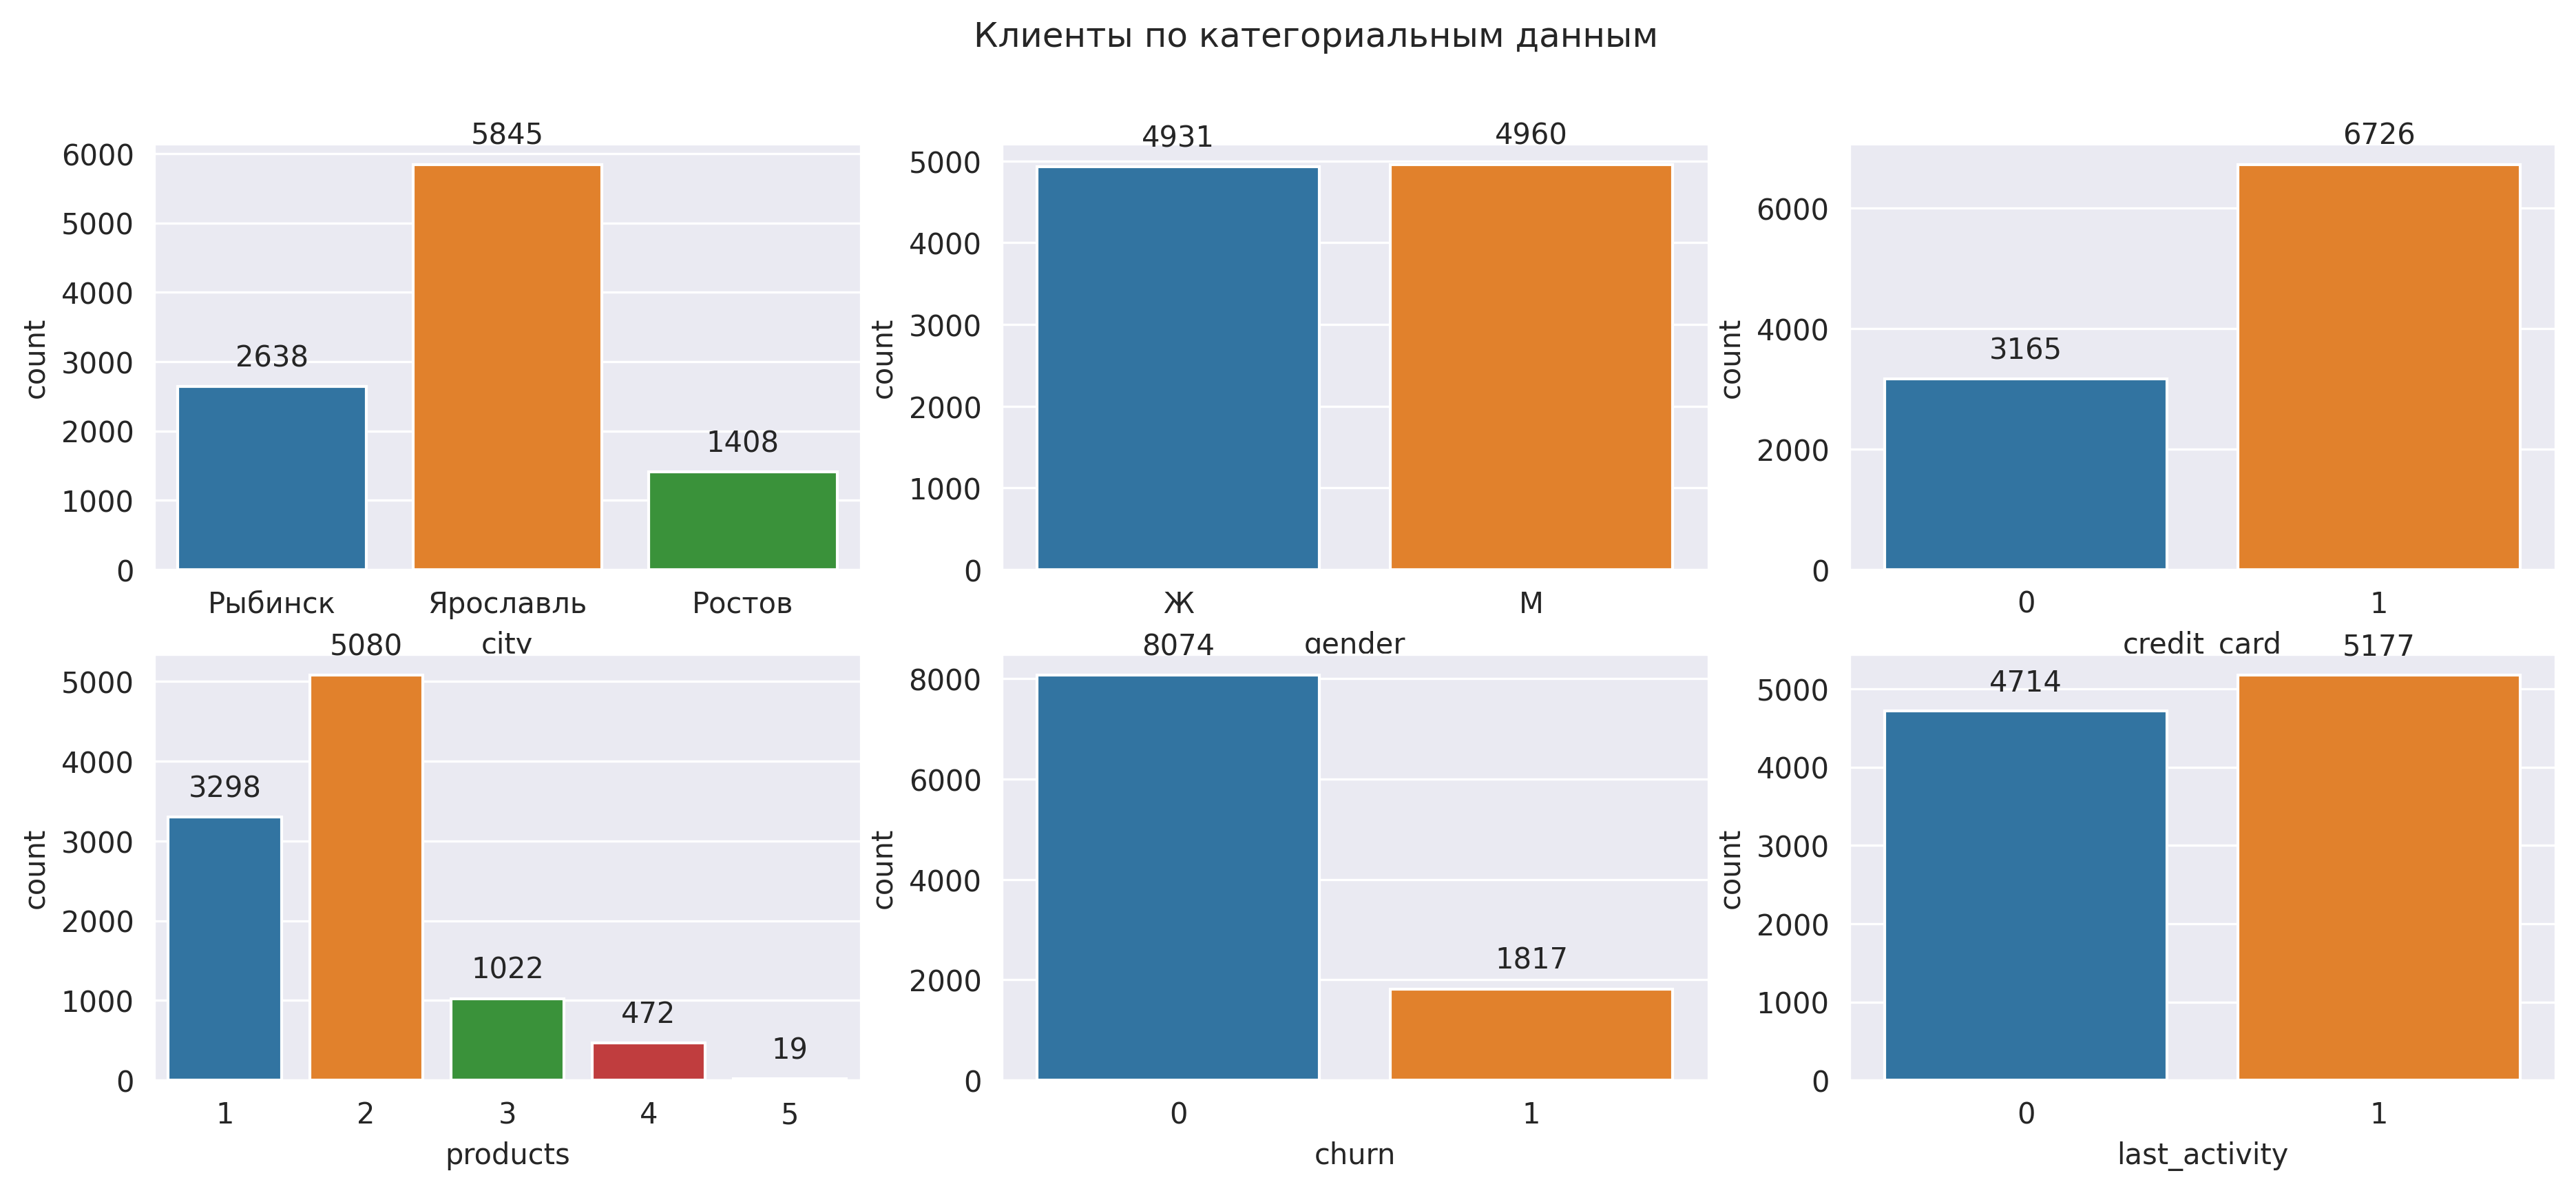

In [25]:
#посмотрим теперь на графики распределений. Вначале для категориальных данных:
sns.set_style("darkgrid")
column_list = ['city', 'gender', 'credit_card', 'products', 'churn', 'last_activity']

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 6) 
fig.set_dpi(300)
for variable, subplot in zip(column_list, ax.flatten()):
    splot = sns.countplot(data_banks[variable], ax=subplot)
    for p in splot.patches:
        splot.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width()/2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig.suptitle("Клиенты по категориальным данным");

На графиках видим подтверждение выводам выше, в Ярославле гораздо больше клиентом, затем Рыбинск, потом Ростов; мужчин и женщин примерно поровну; владельцев кредитных карт заметно больше, чем тех, у кого кредиток нет;  в основном у клиентов 2 продукта, заием 1, 3, 4 и 5; отток довольно большой, около 20% клиентов (если точнее, 18%); активных клиентов чуть больше чем неактивных.

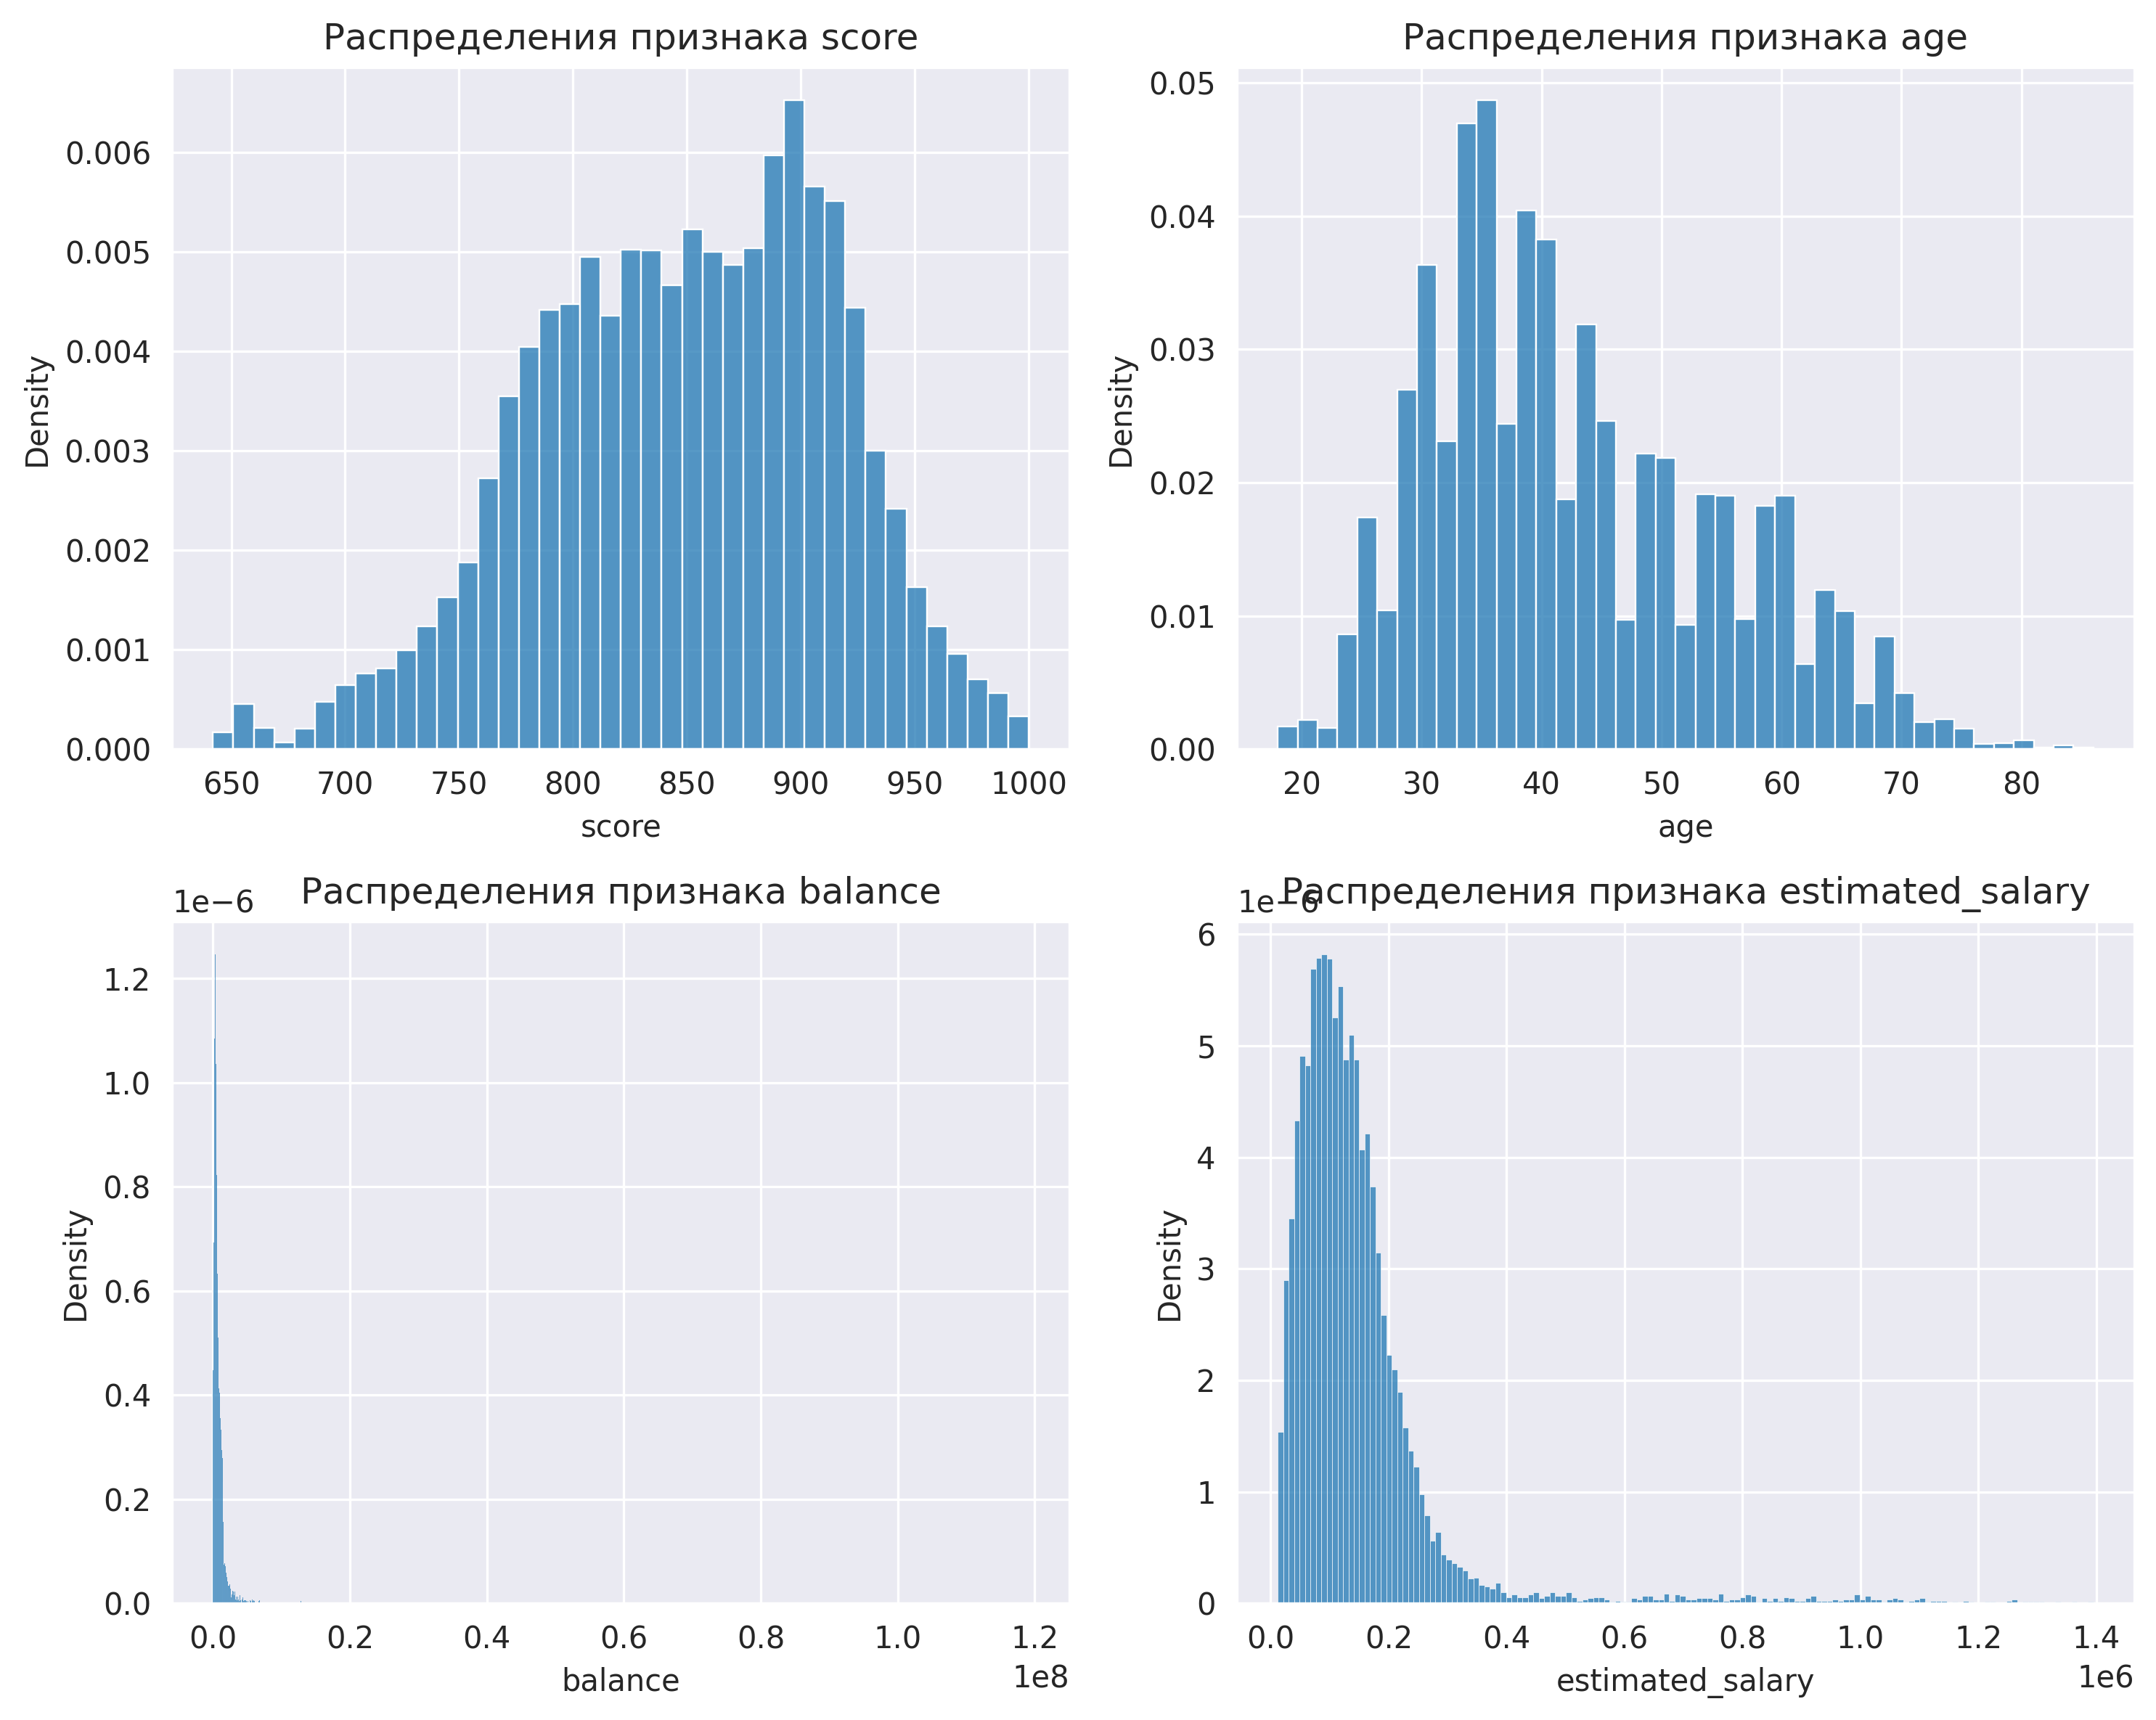

In [26]:
#далее построим графики распределений для количественных данных:
sns.set_style("darkgrid")
column_list = ['score', 'age', 'balance', 'estimated_salary']

fig, axs = plt.subplots(len(column_list) // 2, 2)
fig.set_size_inches(10, 8) 
fig.set_dpi(300)

new_axs = [item for sublist in axs for item in sublist]

for i, column in enumerate(column_list):
    sns.histplot(data=data_banks, x=column,  stat='density', common_norm=False, palette="Paired",  ax=new_axs[i])
    new_axs[i].set_title('Распределения признака {}'.format(column))

plt.tight_layout()
plt.show()

На графиках видно, что у большей части клиентов высокий рейтинг, возраст примерно 28-45 лет,и зарплата в пределах 200 тыс.рублей.

### Корреляционный анализ оттока

Нам необходимо проанализировать, как отток клиентов коррелирует с другими параметрами, представленными в датафрейме.
Для этого построим корреляционную матрицу и хитмэп.

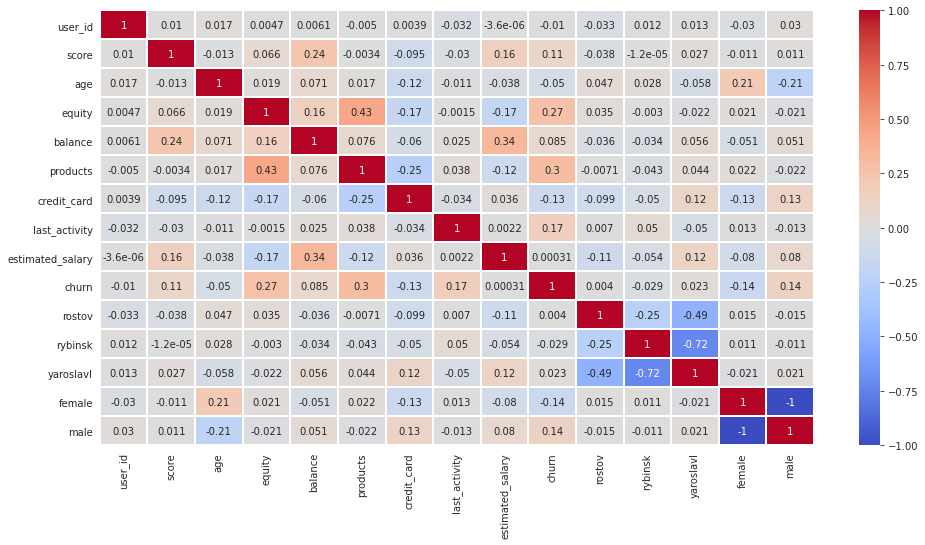

In [27]:
plt.figure(figsize=(16,8))
sns.heatmap (data_banks.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1);

Хитмэп и матрица корреляции говорит нам, что наибольшая корреляция с показателем оттока клиентов у категорий продукты (0.3), оценки объектов собственности (0.27), активности (0.17), пол (0.14), кредитные карты (0.13) и рейтинг (0.11).

Для оценки силы связи в теории корреляции применяется шкала английского статистика Чеддока: слабая — от 0,1 до 0,3; умеренная — от 0,3 до 0,5; заметная — от 0,5 до 0,7; высокая — от 0,7 до 0,9; весьма высокая (сильная) — от 0,9 до 1,0.

Таким образом, наши показатели все имеют слабую силу связи - не более 0.3.

Рассмотрим эти пункты по отдельности для выявления портрета отточного клиента.

### Выделение портрета клиента, который уходит из банка (отточного)

,sum,count,perc
products,,,
1,235,3298,7.13
2,977,5080,19.23
3,297,1022,29.06
4,300,472,63.56
5,8,19,42.11


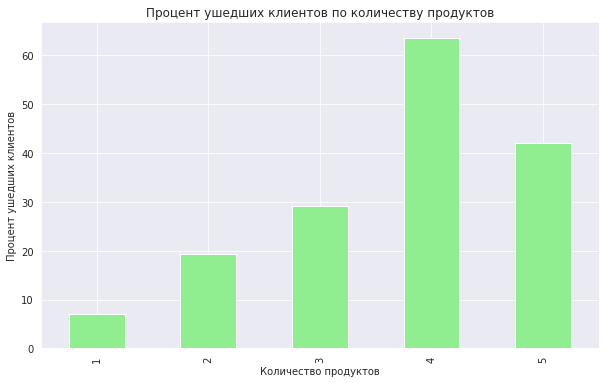

In [28]:
#посмотрим процент ушедших клиентов по количеству продуктов:
churn_prod_data_banks = data_banks.pivot_table (index = 'products', values = 'churn', aggfunc = ['sum', 'count'])
churn_prod_data_banks.columns = churn_prod_data_banks.columns.droplevel(level=1)
churn_prod_data_banks ['perc'] = churn_prod_data_banks['sum']/churn_prod_data_banks['count']*100

churn_prod_data_banks['perc'].plot (
    kind='bar', title = 'Процент ушедших клиентов по количеству продуктов',
    xlabel = 'Количество продуктов', ylabel = 'Процент ушедших клиентов', figsize = (10,6), 
    color = 'lightgreen');
churn_prod_data_banks

Больше всего ушло клиентоа среди тех, у кого было 4 продукта, меньше всего - менее 10% - тех, у кого 1 продукт.

,sum,count,perc
equity,,,
0,90,2551,3.53
1,93,768,12.11
2,166,1039,15.98
3,320,1525,20.98
4,464,1835,25.29
5,576,1905,30.24
6,58,160,36.25
7,37,78,47.44
8,6,17,35.29


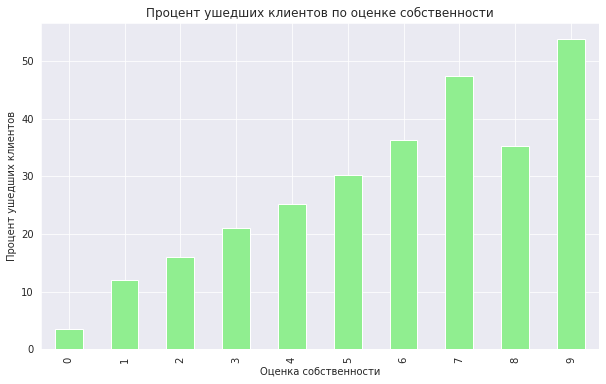

In [29]:
#посмотрим процент ушедших клиентов по оценке собственности:
churn_eq_data_banks = data_banks.pivot_table (index = 'equity', values = 'churn', aggfunc = ['sum', 'count'])
churn_eq_data_banks.columns = churn_eq_data_banks.columns.droplevel(level=1)
churn_eq_data_banks ['perc'] = churn_eq_data_banks['sum']/churn_eq_data_banks['count']*100

churn_eq_data_banks['perc'].plot (
    kind='bar', title = 'Процент ушедших клиентов по оценке собственности',
    xlabel = 'Оценка собственности', ylabel = 'Процент ушедших клиентов', figsize = (10,6), color = 'lightgreen');
churn_eq_data_banks

В целом, можно практически определенно заявить, что чем выше оценка собственности, тем больше процент отточных клиентов.

,sum,count,perc
last_activity,,,
0,540,4714,11.46
1,1277,5177,24.67


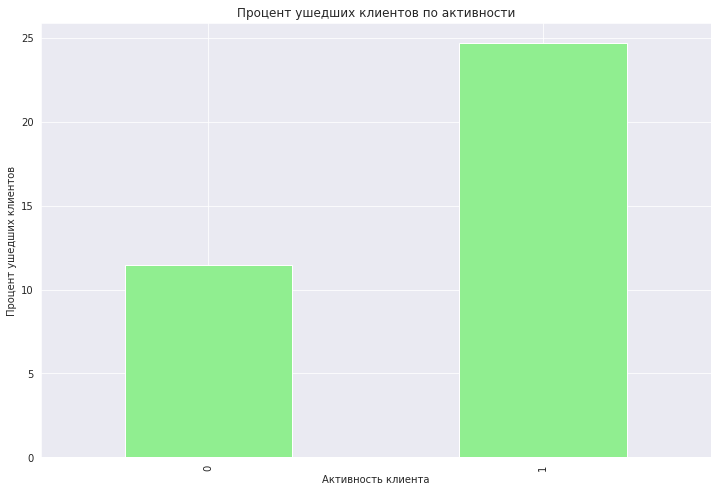

In [30]:
#посмотрим процент ушедших клиентов по активности:
churn_act_data_banks = data_banks.pivot_table (index = 'last_activity', values = 'churn', aggfunc = ['sum', 'count'])
churn_act_data_banks.columns = churn_act_data_banks.columns.droplevel(level=1)
churn_act_data_banks ['perc'] = churn_act_data_banks['sum']/churn_act_data_banks['count']*100

churn_act_data_banks['perc'].plot(
    kind='bar', title = 'Процент ушедших клиентов по активности', figsize = (12,8), 
    color = 'lightgreen', ylabel = 'Процент ушедших клиентов', xlabel = 'Активность клиента');
churn_act_data_banks

Интересно - среди ушедших клиентов авктивных в 2 раза больше, чем неактивных, хотя казалось бы, должно быть наоборот.

,sum,count,perc
gender,,,
Ж,635,4931,12.88
М,1182,4960,23.83


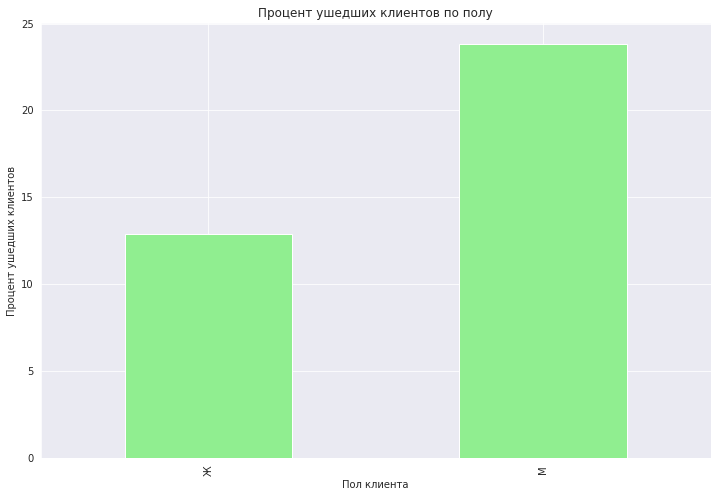

In [31]:
#посмотрим процент ушедших клиентов по полу:
churn_gen_data_banks = data_banks.pivot_table (index = 'gender', values = 'churn', aggfunc = ['sum', 'count'])
churn_gen_data_banks.columns = churn_gen_data_banks.columns.droplevel(level=1)
churn_gen_data_banks ['perc'] = churn_gen_data_banks['sum']/churn_gen_data_banks['count']*100

churn_gen_data_banks['perc'].plot(
    kind='bar', title = 'Процент ушедших клиентов по полу', figsize = (12,8), color = 'lightgreen', 
    xlabel = 'Пол клиента', ylabel = 'Процент ушедших клиентов');
churn_gen_data_banks

Среди ушедших намного больше мужчин, чем женщин.

,sum,count,perc
credit_card,,,
0,815,3165,25.75
1,1002,6726,14.90


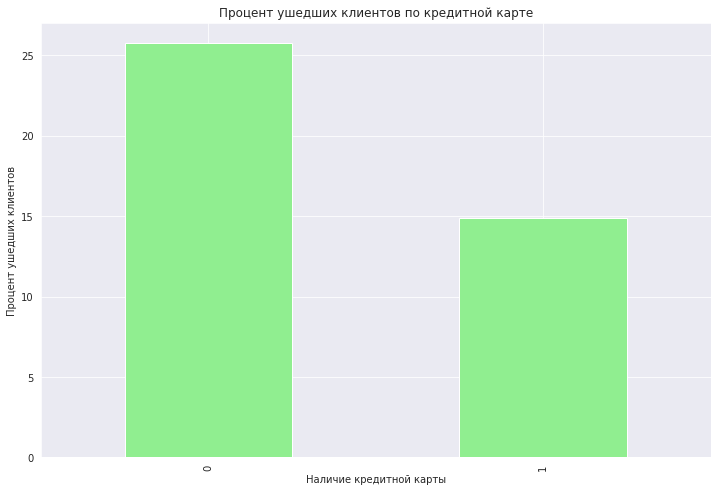

In [32]:
#посмотрим процент ушедших клиентов по кредитным картам:
churn_card_data_banks = data_banks.pivot_table (index = 'credit_card', values = 'churn', aggfunc = ['sum', 'count'])
churn_card_data_banks.columns = churn_card_data_banks.columns.droplevel(level=1)
churn_card_data_banks ['perc'] = churn_card_data_banks['sum']/churn_card_data_banks['count']*100

churn_card_data_banks['perc'].plot(
    kind='bar', figsize = (12,8), color = 'lightgreen', xlabel = 'Наличие кредитной карты',
    title = 'Процент ушедших клиентов по кредитной карте',
    ylabel = 'Процент ушедших клиентов');
churn_card_data_banks

Получается, что чаще уходя те, у кого кредитных карт нет.

,sum,count,perc
score,,,
706.00,1,11,9.09
707.00,1,6,16.67
727.00,1,12,8.33
728.00,1,9,11.11
730.00,1,8,12.50
733.00,1,14,7.14
736.00,1,8,12.50
737.00,1,13,7.69
739.00,1,14,7.14


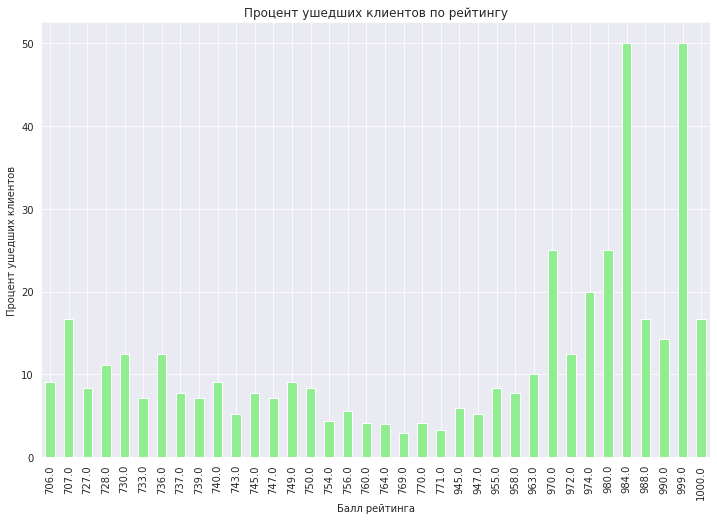

In [33]:
#посмотрим процент ушедших клиентов по рейтингу:
churn_sc_data_banks = data_banks.pivot_table (index = 'score', values = 'churn', aggfunc =['sum', 'count'])
churn_sc_data_banks.columns = churn_sc_data_banks.columns.droplevel(level=1)
churn_sc_data_banks ['perc'] = churn_sc_data_banks['sum']/churn_sc_data_banks['count']*100
churn_sc_data_banks = churn_sc_data_banks [churn_sc_data_banks['sum']==1]

churn_sc_data_banks ['perc'].plot (
    kind = 'bar', figsize = (12,8), color = 'lightgreen', xlabel = 'Балл рейтинга',
    title = 'Процент ушедших клиентов по рейтингу',
    ylabel = 'Процент ушедших клиентов');
churn_sc_data_banks

Интересно, что уходят люди с высоким баллом рейтинга - не ниже 706. В целом в основном до 771 шло некторое снижение спеременным успехом, однако после начинается устойчивый рост оттока клиентов.

Также проверим 3 важных, на мой взгляд, показателя, у которых нет высокой корреляции с оттоком, но которые могут быть важны для выделения портрета отточного клиента.

,sum,count,perc
city,,,
Ростов,264,1408,18.75
Рыбинск,436,2638,16.53
Ярославль,1117,5845,19.11


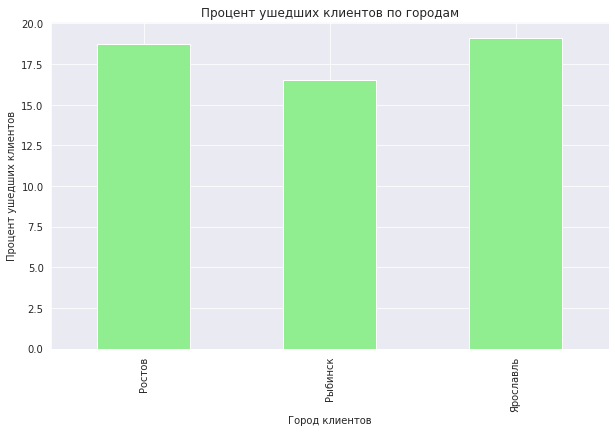

In [34]:
#посмотрим процент ушедших клиентов по городу:
churn_city_data_banks = data_banks.pivot_table (index = 'city', values = 'churn', aggfunc =['sum', 'count'])
churn_city_data_banks.columns = churn_city_data_banks.columns.droplevel(level=1)
churn_city_data_banks ['perc'] = churn_city_data_banks['sum']/churn_city_data_banks['count']*100

churn_city_data_banks['perc'].plot (
    kind='bar', title = 'Процент ушедших клиентов по городам',
    xlabel = 'Город клиентов', ylabel = 'Процент ушедших клиентов', figsize = (10,6), 
    color = 'lightgreen');
churn_city_data_banks

Особой разницы между клиентами из разных городов нет.

,sum,count,perc
age,,,
18.00,1,13,7.69
19.00,1,15,6.67
20.00,3,22,13.64
21.00,4,14,28.57
22.00,4,26,15.38
...,...,...,...
81.00,0,4,0.00
82.00,0,2,0.00
83.00,0,3,0.00


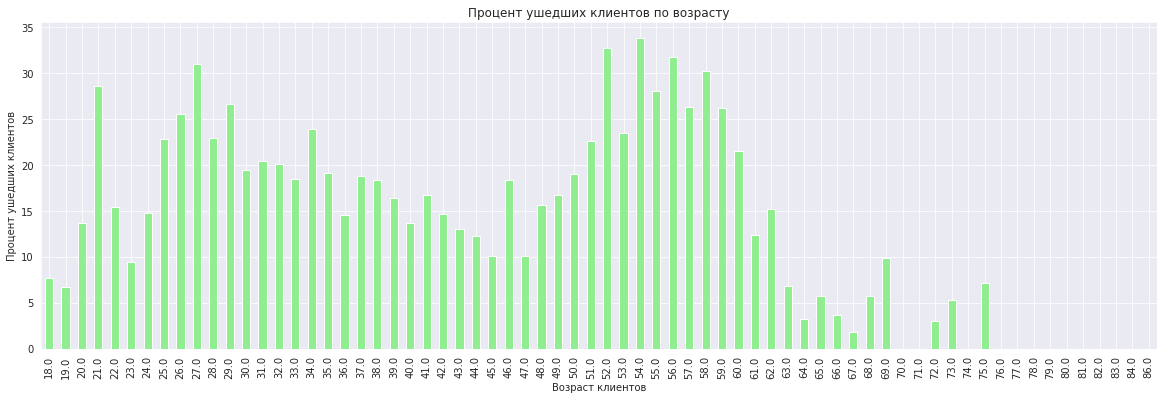

In [35]:
#посмотрим процент ушедших клиентов по возрасту:
churn_age_data_banks = data_banks.pivot_table (index = 'age', values = 'churn', aggfunc =['sum', 'count'])
churn_age_data_banks.columns = churn_age_data_banks.columns.droplevel(level=1)
churn_age_data_banks ['perc'] = churn_age_data_banks['sum']/churn_age_data_banks['count']*100

churn_age_data_banks['perc'].plot (
    kind='bar', title = 'Процент ушедших клиентов по возрасту',
    xlabel = 'Возраст клиентов', ylabel = 'Процент ушедших клиентов', figsize = (20,6), 
    color = 'lightgreen');
churn_age_data_banks

Согласно графику, много отточных среди клиентов в возрасте 25-35 лет и 46-62 года. После 63 лет отток минимален.

Тк на момент создания аналогичного графика для зарплаты стало понятно, что вариативности данных сдишком много и на данном этапе лучше разделить зарплаты на несколько крупных блоков:
    - до 50 тыс.рублей;
    - 51-100 тыс.рублей;
    - 101-150 тыс.рублей;
    - 151-200 тыс.рублей;
    - более 201 тыс.рублей.
    Возможно, стоило также сделать на графике с возрастом, однако там заметно меньше вариативность данных, оставим как есть на данный момент.

In [36]:
#создадим функцию salary_group для распределения клиентов по зарплате:
def salary_group(estimated_salary):
    if 50000 > estimated_salary:
        return '1.<50'
    if 100000 >= estimated_salary >= 51000:
        return '2.51-100'
    if 150000 >= estimated_salary >= 101000:
        return '3.101-150'
    if 200000 >= estimated_salary >= 151000:
        return '4.151-200'
    if 201000 >= estimated_salary:
        return '5.>201'   
#применим функцию salary_group и добавим новый столбец в датафрейм:
data_banks['salary_group'] = data_banks['estimated_salary'].apply (salary_group)
display (data_banks.head())

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn,rostov,rybinsk,yaroslavl,female,male,salary_group
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,2.51-100
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,2.51-100
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,3.101-150
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,4.151-200
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,2.51-100


,sum,count,perc
salary_group,,,
1.<50,173,1160,14.91
2.51-100,444,2669,16.64
3.101-150,508,2506,20.27
4.151-200,347,1680,20.65
5.>201,31,158,19.62


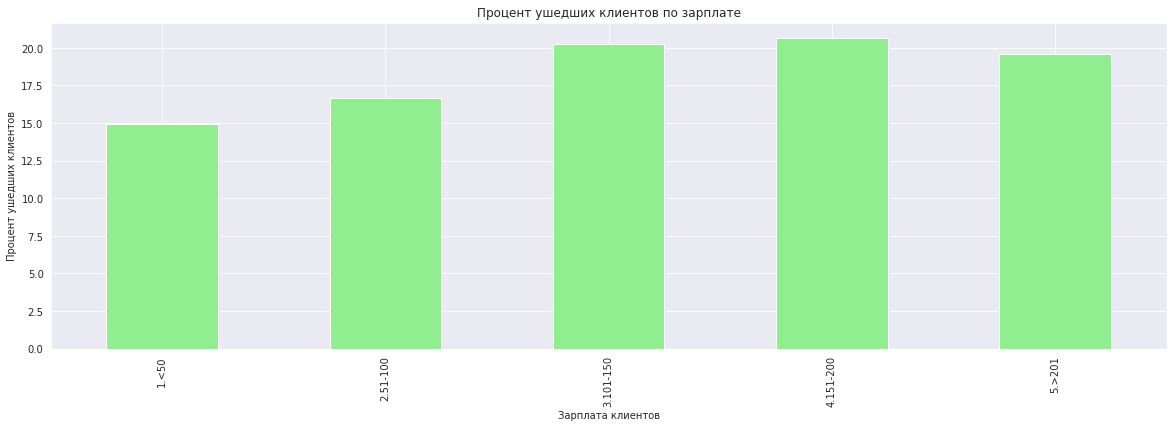

In [37]:
#а вот теперь можно посмотреть процент ушедших клиентов по зарплате:
churn_sal_data_banks = data_banks.pivot_table (index = 'salary_group', values = 'churn', aggfunc =['sum', 'count'])
churn_sal_data_banks.columns = churn_sal_data_banks.columns.droplevel(level=1)
churn_sal_data_banks ['perc'] = churn_sal_data_banks['sum']/churn_sal_data_banks['count']*100

churn_sal_data_banks['perc'].plot (
    kind='bar', title = 'Процент ушедших клиентов по зарплате',
    xlabel = 'Зарплата клиентов', ylabel = 'Процент ушедших клиентов', figsize = (20,6), 
    color = 'lightgreen');
churn_sal_data_banks

Таким образом, наибольший отток у клиентов с зп 151-200 тыс.рублей, почти также - у тех, у кото от 101 до 150 тыс. и более 200 тыс. Меньше всего отток у тех, у кого зп менее 50 тыс. руюлей.

### Вывод по исследовательскому анализу данных

Таким образом, соберем примерный портрет отточного клиента:
    
    Это чаще всего
    - мужчина
    - с 4 (или реже 5) продуктами
    - не ниже 7 баллами оценки собственности
    - активный
    - без кредиток
    - с кредитным рейтингом не ниже 970
    - чаще в возрасте 25-35 лет или 46-62 года
    - с зп от 101 тыс.рублей
    - немного чаще из Ярославля или Рыбинска

## Проверка статистических гипотез

### Проверка гипотезы различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

Нам нужно проверить гипотезу различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, кто пользуются одним.
Первым делом проверим данные на нормальность.

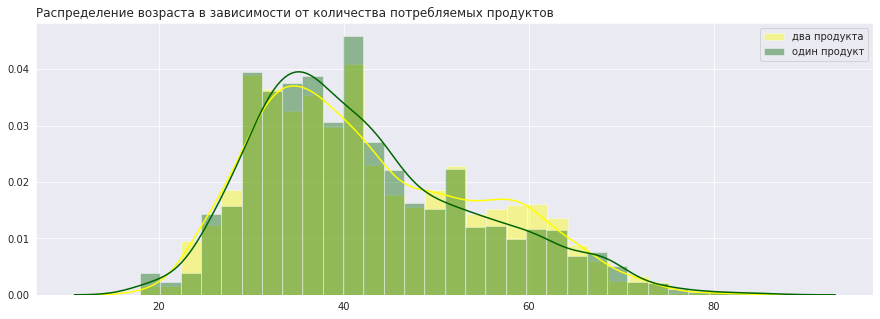

In [38]:
plt.figure(figsize=(15, 5))

sns.distplot(data_banks[data_banks['products'] == 2]['age'], color = 'yellow', label = 'два продукта')
sns.distplot(data_banks[data_banks['products'] < 2]['age'], color = 'darkgreen', label = 'один продукт')

plt.title('Распределение возраста в зависимости от количества потребляемых продуктов', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

Распределение в целом похоже на нормальное.

Таким образом, определим основную и альтернативную гипотезы:

H0 - Возраст клиентов, которые пользуются двумя продуктами банка и теми, кто пользуются одним, одинаков.

H1 - Возраст клиентов, которые пользуются двумя продуктами банка и теми, кто пользуются одним, различаются.

Уровень значимости стандартно = 0.05

Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод st.stats.ttest_ind., тк имеется собственно две генеральные совокупности, по графику распределения совокупностей близки к нормальным.
Ттест или т-статистика или критерий Стьюдента является параметрическим критерием, что означает, что он предполагает нормальное распределение данных и что точки данных независимы друг от друга.

In [39]:
alpha = .05    
results = st.stats.ttest_ind(data_banks[data_banks['products'] == 2]['age'], 
                             data_banks[data_banks['products'] < 2]['age'])

print('p-значение: ', results.pvalue) # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.04966547322757954
Отвергаем нулевую гипотезу


Итак, получается, что возраст тех, кто пользуется двумя продуктами банка и тех, кто пользуктся одним, различен.

### Проверка гипотезы о зависимости наличия  кредитной карты с уходом пользователей

Сформулируем нулевую и альтернативную гипотезы:

H0 - Доля ушедших клиентов с кредитной картой и без кредитной карты одинаковая.

H1 - Доля ушедших клиентов с кредитной картой и без кредитной карты различается.

Для подтверждения гипотезы (сравнение долей в генеральной совокупности) используется Z-тест, который подразумевает тест на гипотезу,  определяющий, отличаются ли средства двух наборов данных при заданной дисперсии. Для снижения ошибки первого рода используется метод Шидака (повышение мощности проводимого теста).

In [40]:
withCard = data_banks.query('credit_card == 1 & churn == 1')['user_id']
withNoCard = data_banks.query('credit_card == 0 & churn == 1')['user_id']
ztest(withCard, withNoCard, value= 0 )

(2.609215736360758, 0.009075000945119097)

Тк второе значение (p-value) сравнивает результат теста с alpha = 0.05 и оно меньше, то таким образом, мы отвергаем нулевую гипотезу и говорим, что доля ушедших клиентов с кредитной картой и без кредитной карты различается.

Итак, наличие кредитных карт влияет на отток, а возраст тех, кто пользуется двумя продуктами банка и тех, кто пользуется одним, различен.

## Сегментация пользователей

### Изучение распределения пользователей по сегментам на основе данных

Итак, у нас  сегменты распределяются по количеству используемых продуктов. Мы знаем, что продуктов 5, следовательно, и сегментов также 5.

На мой взгляд, важными кажутся категории пол, возраст, город, оценка объектов собственности, рейтинг, количество используемых продуктов, наличие кредитной карты, активность.

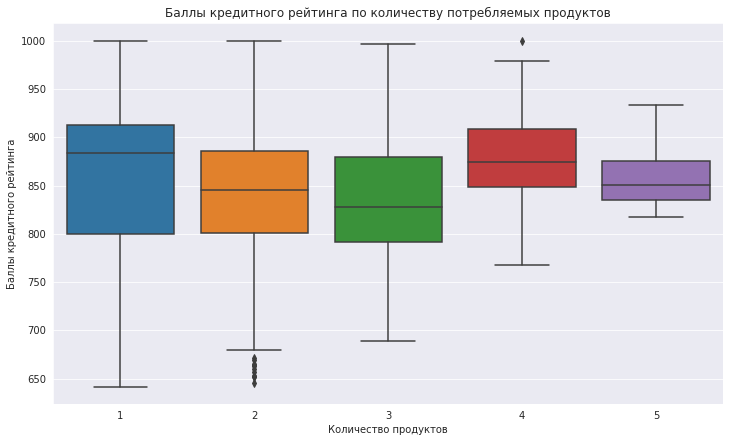

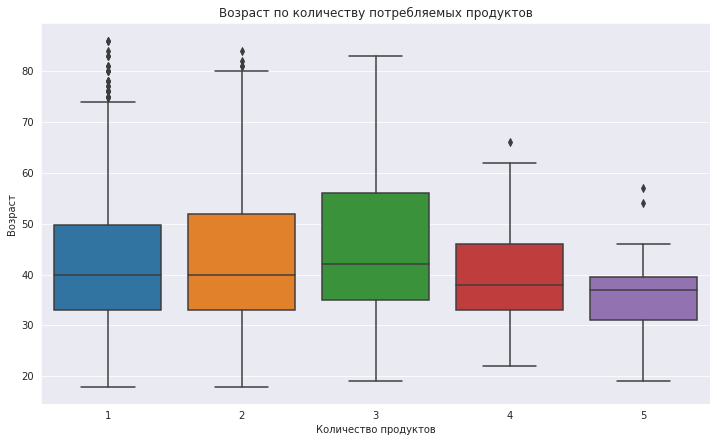

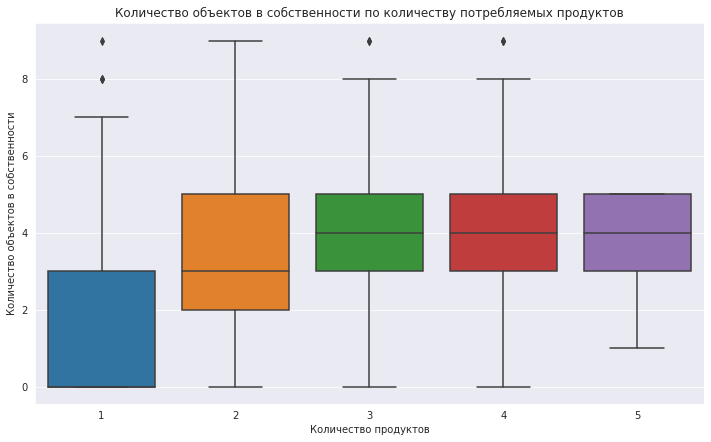

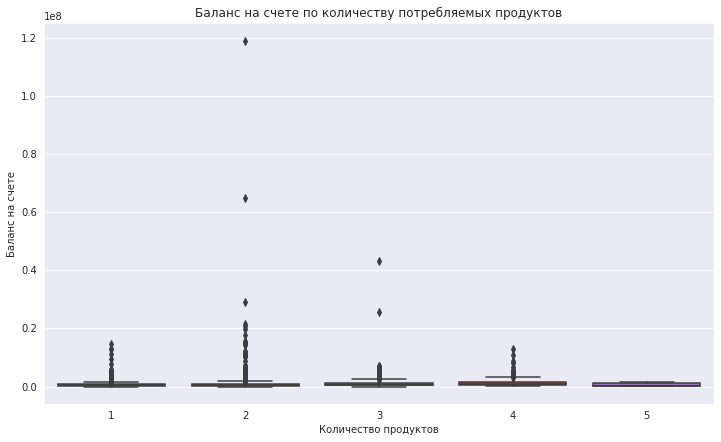

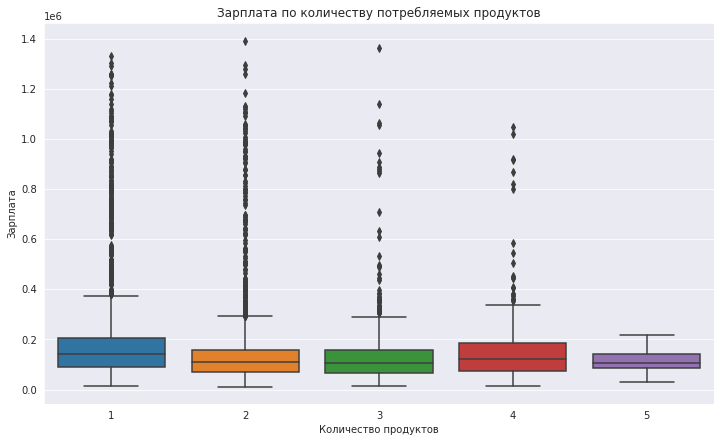

In [41]:
#сгруппируем пользователей по количеству продуктов и сравним через boxplot:
titles = ['score', 'age', 'equity', 'balance', 'estimated_salary']
titles_segments = ['Баллы кредитного рейтинга', \
                  'Возраст', \
                  'Количество объектов в собственности', \
                  'Баланс на счете', \
                  'Зарплата']

for i in range(len(titles)):
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='products', y=titles[i], data=data_banks)
    ax = plt.gca()
    ax.set_xlabel('Количество продуктов')
    ax.set_ylabel(titles_segments[i])
    plt.title(titles_segments[i] + ' по количеству потребляемых продуктов');

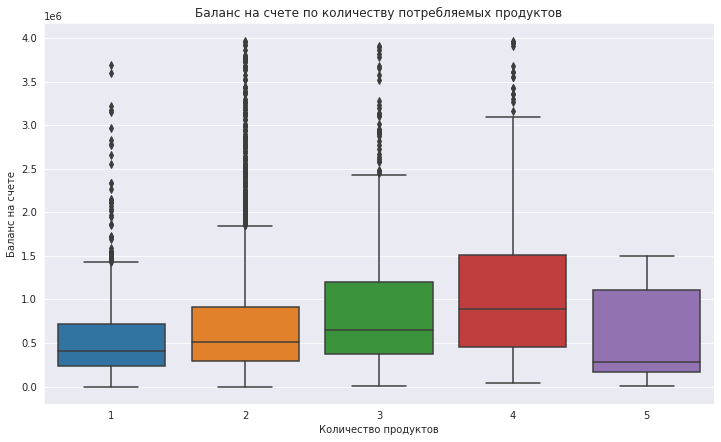

In [42]:
#отдельно проработаем момент с выбросами по балансу, из-за которых график получается ненаглядным
#для этого сочтем выбросом и уберем из датафрейма клиентов с очень высоким балансом выше 4 млн.рублей,тк далее идут только единичные выбросы
data_banks = data_banks[data_banks['balance']<4000000]
#сгруппируем пользователей по количеству продуктов и сравним через boxplot:
titles = ['balance']
titles_balance = ['Баланс на счете', ]

for i in range(len(titles)):
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='products', y=titles[i], data=data_banks)
    ax = plt.gca()
    ax.set_xlabel('Количество продуктов')
    ax.set_ylabel(titles_balance[i])
    plt.title(titles_balance[i] + ' по количеству потребляемых продуктов');

Баллы кредитного рейтинга в целом у всех довольно высоки. 

С возрастом используется большее число продуктов, однако пенсионеры, в основном используют 1-2.

В основном от 2 до 5 объектов в собственности. У тех, у кого 1 продукт - меньшее количество собственности.

Баланс на счете выше у тех, у кого 3-5 продуктов.

У клиентов с 5 продуктами зарплата заметно ниже.

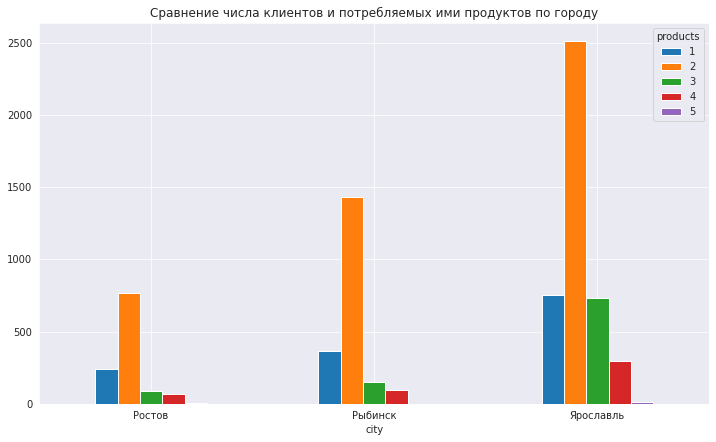

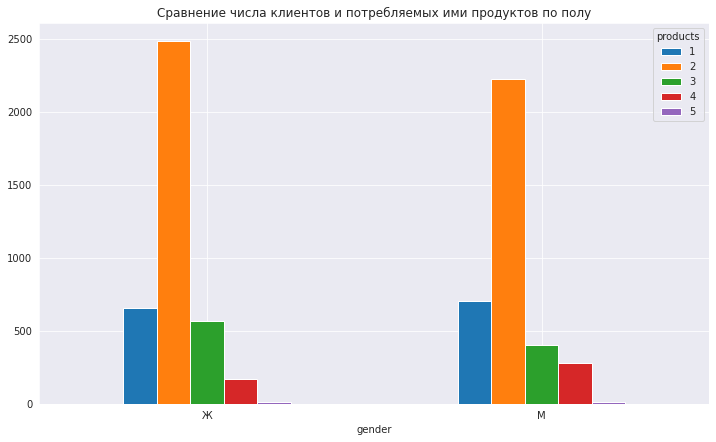

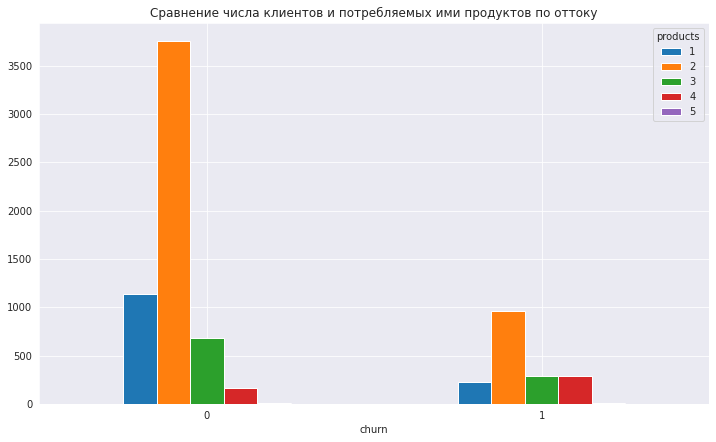

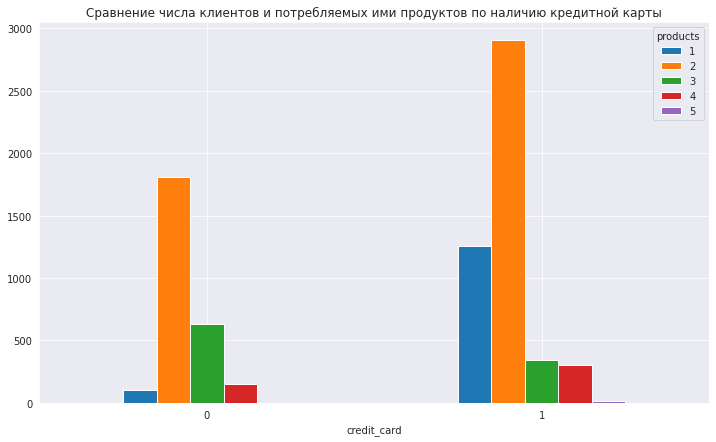

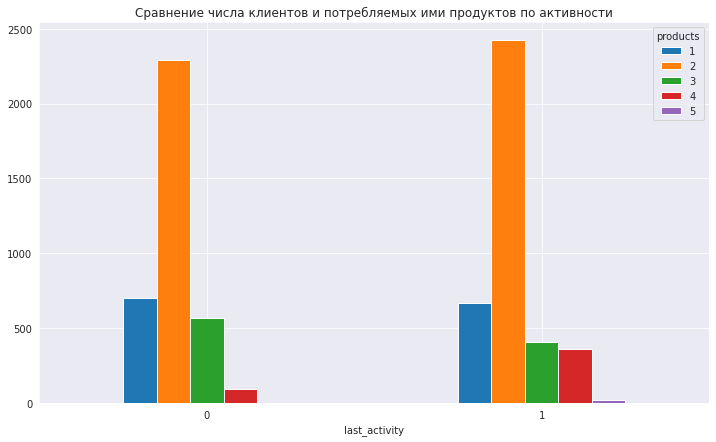

In [43]:
#для дискретных параметров стоит построить столбчатые диаграммы:
titles = ['city', 'gender', 'churn', 'credit_card', 'last_activity']
titles_segments = ['по городу', \
                  'по полу', \
                  'по оттоку', \
                  'по наличию кредитной карты', \
                  'по активности']

for i in range(len(titles)):
    data_banks.pivot_table(index=titles[i], columns='products', values='user_id', aggfunc='count').\
    plot(kind='bar', figsize=(12, 7), grid=True, \
         title='Сравнение числа клиентов и потребляемых ими продуктов ' + titles_segments[i])
    ax = plt.gca()
    plt.xticks(rotation=0);

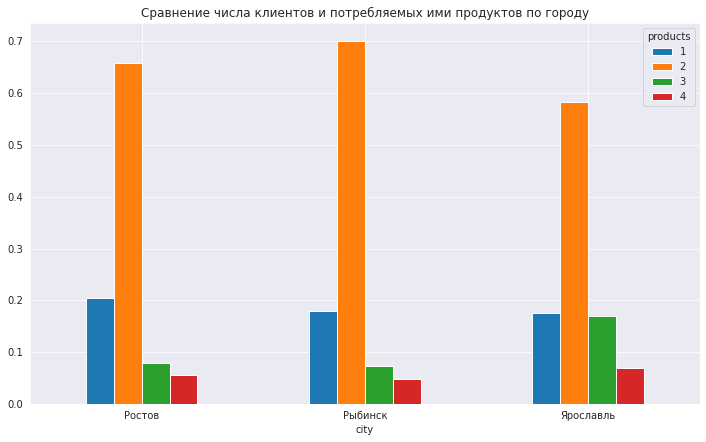

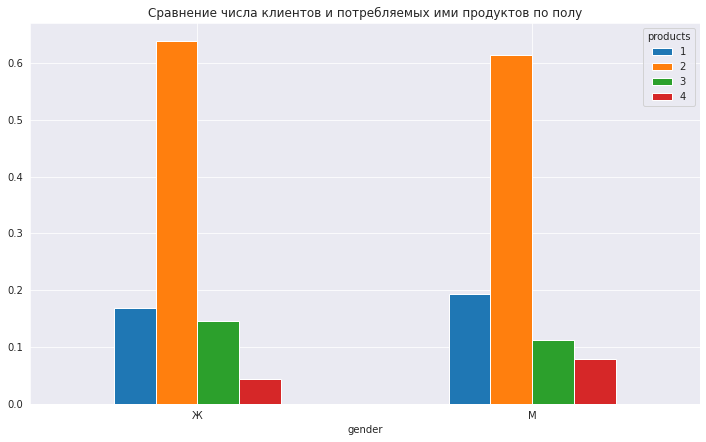

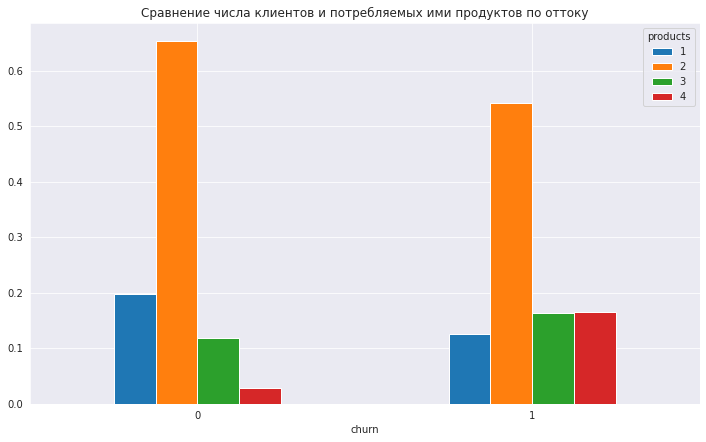

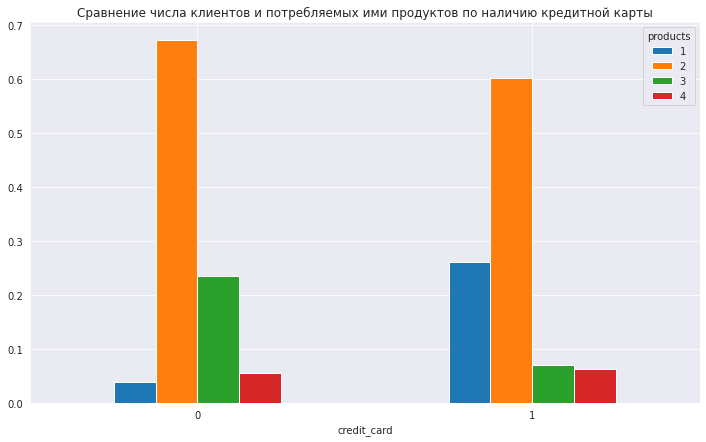

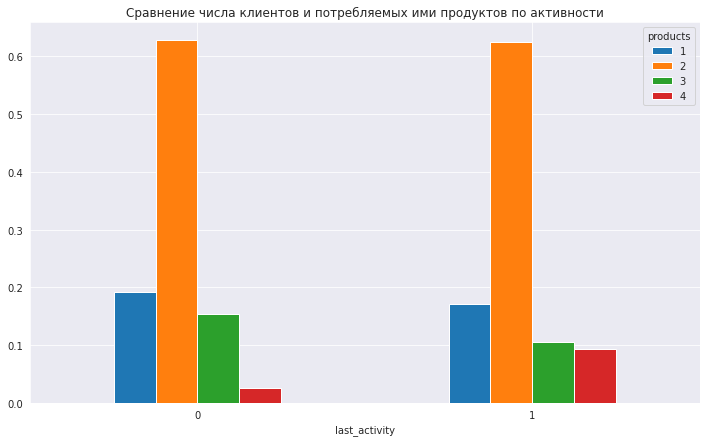

In [44]:
#также выведем эти графики в относительных значениях:
for i in range(len(titles)):
    segment = data_banks.pivot_table(index=titles[i], columns='products', values='user_id', aggfunc='count')
    segment['sum'] = segment.sum(axis=1)
    for j in range(1,5):
        segment[j] = segment[j] / segment['sum']
    segment.iloc[:,0:4].plot(kind='bar', figsize=(12, 7), grid=True, 
                          title='Сравнение числа клиентов и потребляемых ими продуктов ' + titles_segments[i])
    ax = plt.gca()
    plt.xticks(rotation=0);

Больше всего клиентов всех сегментов в Ярославле.

Женщин немного больше, чем мужчин.

Тех, кто остался, заметно больше, чем ушедших.

Тех, у кого есть карта, намного больше чем клиентов без нее.

Количество продуктов не зависит от активности.

Также посмотрим общее распределение по продуктам.

In [45]:
#количество пользователей по продуктам:
prod_data_banks = data_banks.groupby('products')['products'].count().to_frame()
prod_data_banks.columns = ['products_clients']
prod_data_banks

,products_clients
products,
1,1362
2,4711
3,973
4,456
5,19


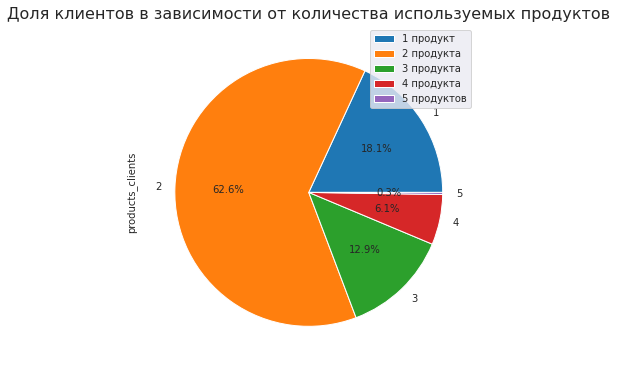

In [46]:
prod_data_banks.plot(kind = 'pie', y ='products_clients', autopct='%1.1f%%', figsize= (6,8))
plt.title('Доля клиентов в зависимости от количества используемых продуктов', fontsize = 16)
plt.legend(['1 продукт','2 продукта','3 продукта','4 продукта', '5 продуктов'])
plt.show()

In [47]:
data_banks.pivot_table(index='products', aggfunc='mean')

,age,balance,churn,credit_card,equity,estimated_salary,female,last_activity,male,rostov,rybinsk,score,user_id,yaroslavl
products,,,,,,,,,,,,,,
1,42.46,536798.88,0.16,0.92,3.10,115013.45,0.48,0.49,0.52,0.18,0.27,836.24,172418.01,0.56
2,42.73,684387.07,0.20,0.62,3.34,118189.41,0.53,0.51,0.47,0.16,0.30,842.46,171164.43,0.53
3,45.71,847491.95,0.30,0.35,3.61,118225.69,0.58,0.42,0.42,0.09,0.15,834.82,172434.13,0.75
4,39.60,1097028.90,0.64,0.67,4.13,136881.05,0.38,0.79,0.62,0.14,0.21,875.63,170823.92,0.65
5,36.47,610986.63,0.42,1.00,3.68,116652.05,0.47,0.89,0.53,0.21,0.05,859.26,163015.58,0.74


In [48]:
data_banks.pivot_table(index='products', aggfunc='count')

,age,balance,churn,city,credit_card,equity,estimated_salary,female,gender,last_activity,male,rostov,rybinsk,salary_group,score,user_id,yaroslavl
products,,,,,,,,,,,,,,,,,
1,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362,1242,1362,1362,1362
2,4711,4711,4711,4711,4711,4711,4711,4711,4711,4711,4711,4711,4711,4259,4711,4711,4711
3,973,973,973,973,973,973,973,973,973,973,973,973,973,870,973,973,973
4,456,456,456,456,456,456,456,456,456,456,456,456,456,372,456,456,456
5,19,19,19,19,19,19,19,19,19,19,19,19,19,18,19,19,19


Таким образом, у нас выделено 5 сегментов.

1 Сегмент.
•	3298 человек, 33,3%.
•	средний возраст - 42,2 года.
•	средний баланс - 613689 рублей.
•	от 1 до 3 объектов в собственности.
•	средняя зарплата составляет 181033 рубля.
•	женщин меньше, чем мужчин.
•	в основном из Ярославля (61%), затем Рыбинска (26%) и Ростова (13%).
•	кредитный рейтинг в среднем составляет 854,41 балл.

2 Сегмент.
•	5080 человек, 51,4%.
•	средний возраст - 42,7 лет.
•	средний баланс - 814664 рублей.
•	от 2 до 5 объектов в собственности.
•	средняя зарплата составляет 130892 рубля.
•	женщин больше, чем мужчин.
•	в основном из Ярославля (54%), затем Рыбинска (30%) и Ростова (16%).
•	кредитный рейтинг в среднем составляет 844,7 балл.

3 Сегмент.
•	1022 человека, 4,8%.
•	средний возраст - 45,64 года.
•	средний баланс - 1001166 рублей.
•	от 3 до 5 объектов в собственности.
•	средняя зарплата составляет 129687 рублей.
•	женщин больше, чем мужчин.
•	в основном из Ярославля (76%), затем Рыбинска (15%) и Ростова (9%).
•	кредитный рейтинг в среднем составляет 837,2 балла.

4 Сегмент.
•	472 человека, 10,3%.
•	средний возраст - 39,86 лет.
•	средний баланс - 1272919 рублей.
•	от 3 до 5 объектов в собственности.
•	средняя зарплата составляет 149392 рубля.
•	женщин меньше, чем мужчин.
•	в основном из Ярославля (65%), затем Рыбинска (21%) и Ростова (14%).
•	кредитный рейтинг в среднем составляет 878,5 баллов.

5 Сегмент.
•	19 человек, 0,2%.
•	средний возраст - 36,47 лет.
•	средний баланс - 610986 рублей.
•	от 3 до 5 объектов в собственности.
•	средняя зарплата составляет 116652 рубля.
•	женщин меньше, чем мужчин.
•	в основном из Ярославля (74%), затем Ростова (21%) и Рыбинска (5%).
•	кредитный рейтинг в среднем составляет 859,3 баллов.

### Приоритезация сегментов, рекомендации для отдела маркетинга

Итак, на мой взгляд, представляется логичным расположить приоритет по оттоку от большего к меньшему.
То есть сначала 2 сегмент, затем 1, 4, 3 и 5.

Для сегмента 2 важно уменьшить отток клиентов, поэтому, возможно, стоит изучить обратную связь и понять, что именно не нравится, возможно, им не хватает какой-то программы лояльности, дополнительных "плюшек" и продуктов,  возможно, учитывая средний возраст 40+, стоит уменьшить какие-то развлекательные активности, рассылки, квесты и тд.

Для сегмента 1 ситуация в целом имеет некоторое сходство, возможно, стоит добавить что-то с повышенным процентом на вкладе или кешбеком по карте на покупки (ср.зп ниже, чем в сегменте 1, больше женщин), вероятно также стоит уменьшить какие-то развлекательные активности.

Для сегмента 4 стоит, возможно, также сфокусироваться на "плюшках" по кешбеку, а также оьратить внимание на преобладание мужчин, возможно, выпустить стильные лаконичные карты или предложить выгодные условия по ипотеке (согласно общедоступной информации, мужчины берут ипотеку чаще, так в ипотечном портфеле Сбербанка количество ипотечных заемщиков-мужчин составляет 55%, в ВТБ 24 - 57%, а в Россельхозбанке - 54%).

Для сегментов 3 и 5 можно сохранять текущие услвоия и следить за тем, чтобы не было ухудшений.

## Вывод

В рамках исследования был проведена предобработка файла, заменены названия столбцов, определены и изучены пропуски и ошибки, проведена проверка на дубликаты, а также закодированы города и пол.

Далее был проведен исследовательский анализ, в ходе которо были определены черты отточного клиента: мужчина, с 4 (или реже 5) продуктами, не ниже 7 баллами оценки собственности, активный, без кредиток, с кредитным рейтингом не ниже 970, чаще в возрасте 25-35 лет или 46-62 года, с зп от 101 тыс.рублей, немного чаще из Ярославля или Рыбинска.

Затем были проверены 2 гипотезы:
1. Проверка гипотезы о зависимости наличия кредитной карты у тех пользователей, которые ушли, и тех, которые остались.
2. Проверка гипотезы о зависимости наличия кредитной карты у тех пользователей, которые ушли, и тех, которые остались.
По результатам было определено, что наличие кредитных карт не влияет на отток, а возраст тех, кто пользуется двумя продуктами банка и тех, кто пользуется одним, различен.

Далее была проведена сегментация пользователей по 5 сегментам по количеству продуктов, в ходе сегментации выявлено, что баллы кредитного рейтинга в целом у всех довольно высоки; с возрастом используется большее число продуктов, однако пенсионеры, в основном используют 1-2; в основном от 2 до 5 объектов в собственности; у тех, у кого 1 продукт - меньшее количество собственности; баланс на счете выше у тех, у кого 2-3 продукта, у клиентов с 5 продуктами зарплата заметно ниже; больше всего клиентов всех сегментов в Ярославле; женщин немного больше, чем мужчин; тех, кто остался, заметно больше, чем ушедших; тех, у кого есть карта, намного больше чем клиентов без нее; количество продуктов не зависит от активности.

Таким образом, было выделено 5 сегментов.

1 Сегмент. • 3298 человек, 33,3%. • средний возраст - 42,2 года. • средний баланс - 613689 рублей. • от 1 до 3 объектов в собственности. • средняя зарплата составляет 181033 рубля. • женщин меньше, чем мужчин. • в основном из Ярославля (61%), затем Рыбинска (26%) и Ростова (13%). • кредитный рейтинг в среднем составляет 854,41 балл.

2 Сегмент. • 5080 человек, 51,4%. • средний возраст - 42,7 лет. • средний баланс - 814664 рублей. • от 2 до 5 объектов в собственности. • средняя зарплата составляет 130892 рубля. • женщин больше, чем мужчин. • в основном из Ярославля (54%), затем Рыбинска (30%) и Ростова (16%). • кредитный рейтинг в среднем составляет 844,7 балл.

3 Сегмент. • 1022 человека, 4,8%. • средний возраст - 45,64 года. • средний баланс - 1001166 рублей. • от 3 до 5 объектов в собственности. • средняя зарплата составляет 129687 рублей. • женщин больше, чем мужчин. • в основном из Ярославля (76%), затем Рыбинска (15%) и Ростова (9%). • кредитный рейтинг в среднем составляет 837,2 балла.

4 Сегмент. • 472 человека, 10,3%. • средний возраст - 39,86 лет. • средний баланс - 1272919 рублей. • от 3 до 5 объектов в собственности. • средняя зарплата составляет 149392 рубля. • женщин меньше, чем мужчин. • в основном из Ярославля (65%), затем Рыбинска (21%) и Ростова (14%). • кредитный рейтинг в среднем составляет 878,5 баллов.

5 Сегмент. • 19 человек, 0,2%. • средний возраст - 36,47 лет. • средний баланс - 610986 рублей. • от 3 до 5 объектов в собственности. • средняя зарплата составляет 116652 рубля. • женщин меньше, чем мужчин. • в основном из Ярославля (74%), затем Ростова (21%) и Рыбинска (5%). • кредитный рейтинг в среднем составляет 859,3 баллов.

И наконец проведена приоритезация сегментов и даны рекомендации для отдела маркетинга "Метанпромбанка":

Для сегмента 2 важно уменьшить отток клиентов, поэтому, возможно, стоит изучить обратную связь и понять, что именно не нравится, возможно, им не хватает какой-то программы лояльности, дополнительных "плюшек" и продуктов, возможно, учитывая средний возраст 40+, стоит уменьшить какие-то развлекательные активности, рассылки, квесты и тд.

Для сегмента 1 ситуация в целом имеет некоторое сходство, возможно, стоит добавить что-то с повышенным процентом на вкладе или кешбеком по карте на покупки (ср.зп ниже, чем в сегменте 1, больше женщин), вероятно также стоит уменьшить какие-то развлекательные активности.

Для сегмента 4 стоит, возможно, также сфокусироваться на "плюшках" по кешбеку, а также оьратить внимание на преобладание мужчин, возможно, выпустить стильные лаконичные карты или предложить выгодные условия по ипотеке (согласно общедоступной информации, мужчины берут ипотеку чаще, так в ипотечном портфеле Сбербанка количество ипотечных заемщиков-мужчин составляет 55%, в ВТБ 24 - 57%, а в Россельхозбанке - 54%).

Для сегментов 3 и 5 можно сохранять текущие условия и следить за тем, чтобы не было ухудшений.